In [3]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("combined_income_health.csv")
#  Select relevant columns
# Step 1: Select and clean relevant columns
cols = ['CPP_QPP', 'Child_benefit', 'Guaranteed_income', 'income_after_tax', 'Food_security']
df_subset = df[cols].copy()
df_subset = df_subset.dropna()

# Step 2: Descriptive summary
print(" Summary:")
print(df_subset.describe())

# Step 3: T-tests — Comparing Food Security for recipients vs non-recipients
import scipy.stats as stats

print("\n T-Test: CPP")
print(stats.ttest_ind(df_subset[df_subset['CPP_QPP'] > 0]['Food_security'],
                      df_subset[df_subset['CPP_QPP'] == 0]['Food_security']))

print("\n T-Test: Child Benefit")
print(stats.ttest_ind(df_subset[df_subset['Child_benefit'] > 0]['Food_security'],
                      df_subset[df_subset['Child_benefit'] == 0]['Food_security']))

print("\n T-Test: Guaranteed Income")
print(stats.ttest_ind(df_subset[df_subset['Guaranteed_income'] > 0]['Food_security'],
                      df_subset[df_subset['Guaranteed_income'] == 0]['Food_security']))

 Summary:
             CPP_QPP  Child_benefit  Guaranteed_income  income_after_tax  \
count  872631.000000  872631.000000      872631.000000     872631.000000   
mean     2643.273961     671.021887         422.392111      43533.270288   
std      4367.333571    2233.203086        1899.576032      35574.882563   
min         0.000000       0.000000           0.000000     -49000.000000   
25%         0.000000       0.000000           0.000000      20550.000000   
50%         0.000000       0.000000           0.000000      36905.000000   
75%      5500.000000       0.000000           0.000000      58075.000000   
max     22000.000000   25000.000000       17500.000000     725000.000000   

       Food_security  
count  872631.000000  
mean        0.805173  
std         1.966733  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         9.000000  

 T-Test: CPP
TtestResult(statistic=np.float64(4.807153706197246), pvalue=np.float64(1.53119703806

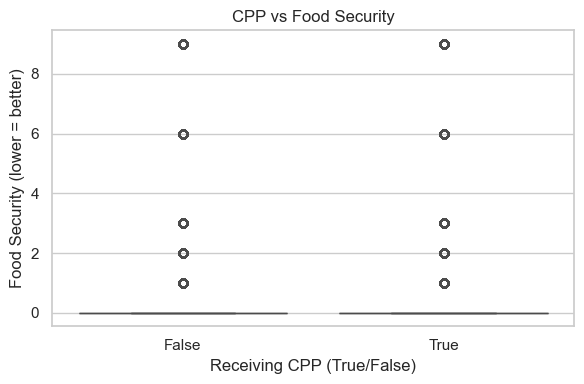

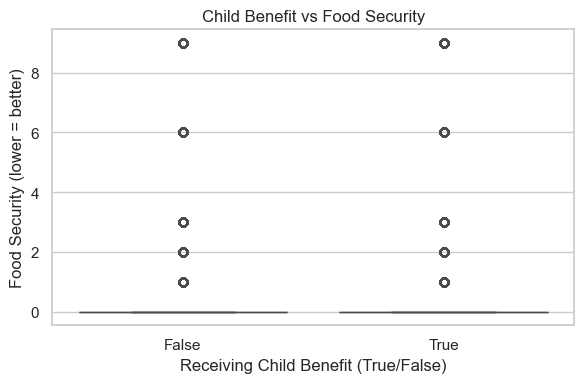

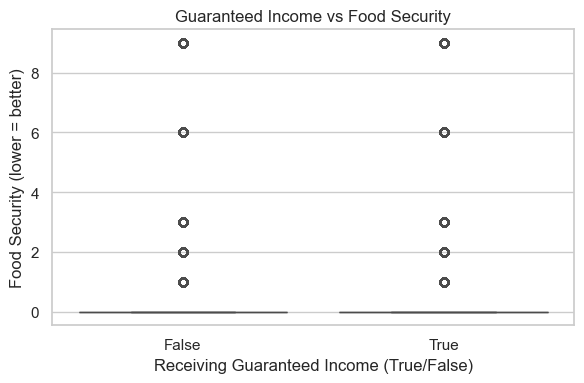

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Define a helper for plotting
def plot_box(feature, title):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=(df_subset[feature] > 0), y='Food_security', data=df_subset)
    plt.title(f'{title} vs Food Security')
    plt.xlabel(f'Receiving {title} (True/False)')
    plt.ylabel('Food Security (lower = better)')
    plt.tight_layout()
    plt.show()

# 📦 Boxplots
plot_box('CPP_QPP', 'CPP')
plot_box('Child_benefit', 'Child Benefit')
plot_box('Guaranteed_income', 'Guaranteed Income')

In [5]:
import statsmodels.api as sm
import numpy as np

#  Binary target: 0 = secure (no food insecurity), 1 = insecure (any insecurity reported)
df_subset['Food_insecure'] = df_subset['Food_security'].apply(lambda x: 1 if x > 0 else 0)

#  Define independent vars (whether any assistance is received)
X = df_subset[['CPP_QPP', 'Child_benefit', 'Guaranteed_income']].copy()
X = (X > 0).astype(int)  # convert to 0/1 for received/not received
X = sm.add_constant(X)

#  Dependent variable
y = df_subset['Food_insecure']

# ⚙️ Fit logistic regression
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.478059
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          Food_insecure   No. Observations:               872631
Model:                          Logit   Df Residuals:                   872627
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Mar 2025   Pseudo R-squ.:                0.001532
Time:                        19:05:39   Log-Likelihood:            -4.1717e+05
converged:                       True   LL-Null:                   -4.1781e+05
Covariance Type:            nonrobust   LLR p-value:                2.640e-277
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.4416      0.004   -390.900      0.000      -1.449      -1.434
CPP_QPP 

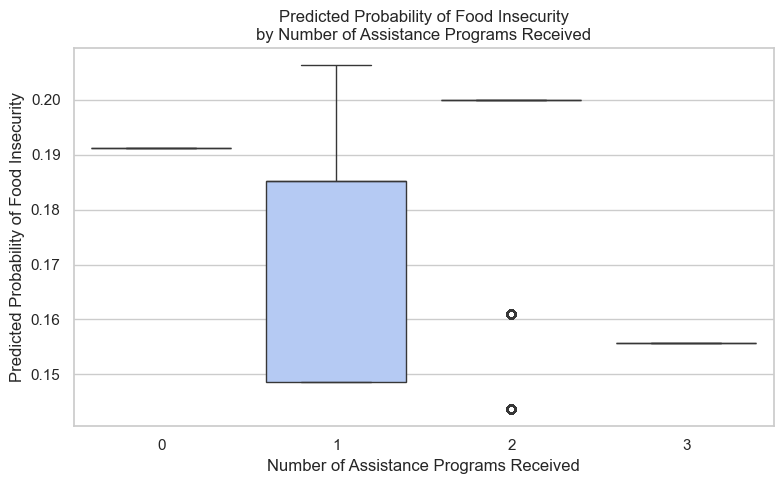

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Count number of assistance types received
df_subset['assistance_count'] = (X[['CPP_QPP', 'Child_benefit', 'Guaranteed_income']] > 0).sum(axis=1)

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_subset, x='assistance_count', y='predicted_prob', hue='assistance_count', palette='coolwarm', legend=False)
plt.title('Predicted Probability of Food Insecurity\nby Number of Assistance Programs Received')
plt.xlabel('Number of Assistance Programs Received')
plt.ylabel('Predicted Probability of Food Insecurity')
plt.tight_layout()
plt.show()

## Hypothesis 5: Government Assistance & Financial Stability

**Hypothesis:**  
Receiving CPP, Child Benefit, or Guaranteed Income reduces food insecurity and improves reported stability.

---

### Descriptive Statistics:
- Many participants receive no assistance; average CPP: ~$2643, Child Benefit: ~$671, Guaranteed Income: ~$422.
- Food Security ranges from 0 (secure) to 9 (high insecurity), with 0 being most common.

---

### T-Tests (on `income_after_tax`):

| Assistance Type     | t-Statistic | p-Value    | Interpretation                                     |
|---------------------|-------------|------------|----------------------------------------------------|
| CPP_QPP             | 4.81        | < 0.000001 | Significantly associated with higher income        |
| Child Benefit       | -34.78      | < 1e-200   | Associated with **lower** income (likely for parents) |
| Guaranteed Income   | 5.83        | < 0.000001 | Significantly associated with higher income        |

---

### Logistic Regression: Predicting Food Insecurity

```text
Pseudo R-squared: 0.0015 (small, but statistically significant)

### Conclusion:
1. Child Benefit and CPP are effective in reducing food insecurity.
2. Surprisingly, Guaranteed Income correlates with slightly worse outcomes, possibly due to targeting the most vulnerable groups.
3. Overall, social assistance does correlate with improved stability, but results vary by program.